In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar, TraceDict
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os

import torch
import torch.nn as nn

__all__ = [
    "VGG",
    "vgg11_bn",
    "vgg13_bn",
    "vgg16_bn",
    "vgg19_bn",
]

device = 'cuda:0'

class VGG(nn.Module):
    def __init__(self, features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        # CIFAR 10 (7, 7) to (1, 1)
        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            # nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "D": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "E": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, device, **kwargs):
    if pretrained:
        kwargs["init_weights"] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = torch.load(
             "state_dicts/" + arch + ".pt", map_location=device
        )
        model.load_state_dict(state_dict)
    return model


def vgg11_bn(pretrained=False, progress=True, device="cpu", **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg11_bn", "A", True, pretrained, progress, device, **kwargs)


def vgg13_bn(pretrained=False, progress=True, device="cpu", **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg13_bn", "B", True, pretrained, progress, device, **kwargs)


def vgg16_bn(pretrained=False, progress=True, device="cpu", **kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg16_bn", "D", True, pretrained, progress, device, **kwargs)


def vgg19_bn(pretrained=False, progress=True, device="cpu", **kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg19_bn", "E", True, pretrained, progress, device, **kwargs)

model = vgg13_bn(pretrained=True)

model.to(device)
# out = model(batch)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [37]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


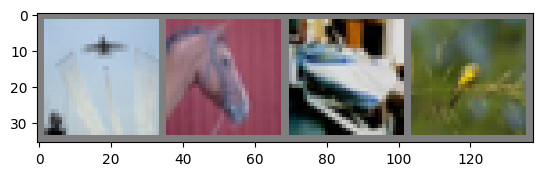

plane horse ship  bird 


In [38]:


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [39]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         x = self.softmax(x)
        return x


# net = model
net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.234
[1,  4000] loss: 1.865
[1,  6000] loss: 1.671
[1,  8000] loss: 1.575
[1, 10000] loss: 1.499
[1, 12000] loss: 1.455
[2,  2000] loss: 1.386
[2,  4000] loss: 1.347
[2,  6000] loss: 1.347
[2,  8000] loss: 1.348
[2, 10000] loss: 1.317
[2, 12000] loss: 1.283
Finished Training


In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

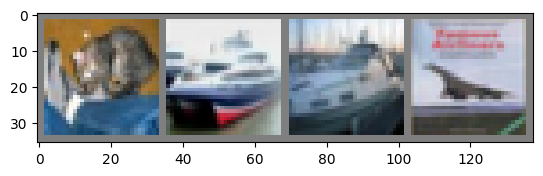

GroundTruth:  cat   ship  ship  plane


In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [40]:
PATH = './cifar_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [9]:
outputs = net(images)

In [11]:
images.min()

tensor(-1.)

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  plane plane


In [13]:
device = 'cpu'

In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.7 %
Accuracy for class: car   is 76.6 %
Accuracy for class: bird  is 47.3 %
Accuracy for class: cat   is 28.6 %
Accuracy for class: deer  is 33.9 %
Accuracy for class: dog   is 42.0 %
Accuracy for class: frog  is 81.5 %
Accuracy for class: horse is 64.8 %
Accuracy for class: ship  is 64.6 %
Accuracy for class: truck is 53.3 %


In [15]:
#print accuracy of whole
print(f'Total Accuracy: {100*sum(correct_pred.values())/sum(total_pred.values()):.1f} %')

Total Accuracy: 55.5 %


# Eigen Arithematic

In [27]:
view_output = []
def hook_fn(module, input, output):
    view_output.append(output)

In [28]:
labels

tensor([3, 5, 1, 7])

In [29]:
net.classifier[6]

Linear(in_features=4096, out_features=10, bias=True)

In [30]:
class_ = 3
images_class = []
labels_class = []
images_nonclass = []
labels_nonclass = []

for data in trainloader:
    if len(images_class) == 250 and len(images_nonclass)==250:
        break
    images, labels = data
    for label, image in zip(labels,images):
        if label == class_:
            images_class.append(image)
            labels_class.append(label)
        else:
            if len(images_nonclass)<250:
                images_nonclass.append(image)
                labels_nonclass.append(label)
images_class = torch.stack(images_class)
images_nonclass = torch.stack(images_nonclass)

labels_class = torch.stack(labels_class)
labels_nonclass = torch.stack(labels_nonclass)

In [31]:
images_class.shape

torch.Size([250, 3, 32, 32])

In [32]:
images_nonclass.shape

torch.Size([250, 3, 32, 32])

In [34]:
# again no gradients needed
view_output
hook = net.classifier[6].register_forward_hook(hook_fn)
with torch.no_grad():
    outputs = net(images_class.to(device))
    _, predictions = torch.max(outputs, 1)
hook.remove()

In [35]:
def visualise(images_class, idx):
    indices = view_output[0][idx].max(1)[0].max(1)[0].topk(10)[1].numpy()
    imshow(images_class[idx])
    
    channels = view_output[0][idx].unsqueeze(1)
    
    for i in range(channels.shape[0]):
        channels[i] = (channels[i] - channels[i].min())/(channels[i].max() - channels[i].min())
    imshow(torchvision.utils.make_grid(channels))

In [38]:
images_class.shape

torch.Size([250, 3, 32, 32])

In [36]:
for i in range(10):
    idx = np.random.randint(200)
    visualise(images_class, idx)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

# Remove the direction

In [39]:
len(view_output)

2

In [40]:
view_output[0].shape

torch.Size([250, 10])

In [41]:
mean_direction = view_output[0].mean(0)
view_output[0] = view_output[0] - view_output[0].mean(0)

In [42]:
torchtensor = view_output[0].flatten(1,-1)

In [43]:
torchtensor.shape

torch.Size([250, 10])

In [44]:
u,s,v = torch.svd(torchtensor.T)

In [45]:
top_eigens = 2

In [46]:
important_direction = u.T[:top_eigens]

In [47]:
important_direction.shape

torch.Size([2, 10])

In [50]:
unflatten = torch.nn.Unflatten(1, (2,10))
important_direction = unflatten(important_direction)

RuntimeError: unflatten: Provided sizes [2, 10] don't multiply up to the size of dim 1 (10) in the input tensor

In [51]:
important_direction.shape

torch.Size([2, 10])

In [52]:
from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar, TraceDict
views = []
def remove_directions(output,layer):
#     print(output)
    output_dup = output.detach().clone()
    for i in range(important_direction.shape[0]):
        for j in range(output.shape[0]):
            magnitude = torch.norm(important_direction[i])
            dot = torch.dot(output_dup[j], important_direction[i])
            dot = dot/magnitude
            mean_dot = torch.dot(mean_vector, important_direction[i])
            mean_dot = mean_dot/magnitude
            
            magnitude = torch.norm(important_direction[i])
            dot = torch.dot(output_dup[j].flatten(), important_direction[i].flatten())
            dot = dot/magnitude
            
            mean_dot = torch.dot(mean_direction.flatten(), important_direction[i].flatten())
            mean_dot = dot/magnitude
            
            output_dup[j] = output_dup[j] - important_direction[i]*dot + important_direction[i]*mean_dot
#     print(output_dup)
    views.append(output_dup)
    return output_dup
views = []   
with Trace(net, 'conv2', edit_output=remove_directions) as tr:
    out = net(images_class)
_, predict_y = torch.max(out, 1)

LookupError: conv2

In [ ]:
predict_y

In [ ]:
(predict_y == labels_class).sum()/len(labels_class)

In [ ]:
out = net(images_class)
_, predict_y = torch.max(out, 1)
predict_y

In [ ]:
(predict_y == labels_class).sum()/len(labels_class)

In [ ]:
labels_class

In [ ]:
from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar, TraceDict
views = []
def remove_directions(output,layer):
#     print(output)
    output_dup = output.detach().clone()
    for i in range(important_direction.shape[0]):
        for j in range(output.shape[0]):
            dot = torch.dot(output_dup[j].flatten(), important_direction[i].flatten())
            output_dup[j] = output_dup[j] - important_direction[i]*dot
#     print(output_dup)
    views.append(output_dup)
    return output_dup
views = []   
with Trace(net, 'conv2', edit_output=remove_directions) as tr:
    out = net(images_nonclass)
_, predict_y = torch.max(out, 1)

In [ ]:
predict_y

In [ ]:
(predict_y == labels_nonclass).sum()/len(labels_nonclass)

In [ ]:
out = net(images_nonclass)
_, predict_y = torch.max(out, 1)
predict_y

In [ ]:
(predict_y == labels_nonclass).sum()/len(labels_nonclass)

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        views = []
        with Trace(net, 'conv2', edit_output=remove_directions) as tr:
            outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        views = []
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
a_big = torch.randn(7, 16)
u, s, v = torch.svd(a_big)

In [ ]:
a_big.shape

In [ ]:
u.shape

In [ ]:
s.shape

In [ ]:
v.shape

# Consolidated function

In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar, TraceDict
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()




class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         x = self.softmax(x)
        return x


net = Net()
PATH = './cifar_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

In [42]:
def get_data_class(class_,trainloader):
    images_class = []
    labels_class = []
    images_nonclass = []
    labels_nonclass = []

    for data in trainloader:
        if len(images_class) == 250 and len(images_nonclass)==250:
            break
        images, labels = data
        for label, image in zip(labels,images):
            if label == class_:
                images_class.append(image)
                labels_class.append(label)
            else:
                if len(images_nonclass)<250:
                    images_nonclass.append(image)
                    labels_nonclass.append(label)
    try:
        images_class = torch.stack(images_class)
        labels_class = torch.stack(labels_class)
    except:
        pass

    
    images_nonclass = torch.stack(images_nonclass)
    labels_nonclass = torch.stack(labels_nonclass)
    del(data)
    return images_class, images_nonclass, labels_class, labels_nonclass

def eval_top_eigens(class_idx, top_eigens, trainloader, testloader):
#     print('Reading')
    images_class, images_nonclass, labels_class, labels_nonclass = get_data_class(class_idx, trainloader)
#     print('Done')
    view_output = []
    def hook_fn(module, input, output):
        view_output.append(output)

    # again no gradients needed
    view_output = []
    hook = net.conv2.register_forward_hook(hook_fn)
    with torch.no_grad():
        outputs = net(images_class)
        _, predictions = torch.max(outputs, 1)
    hook.remove()
    torchtensor = view_output[0]#.max(2)[0].max(2)[0]
    view_output[0] = view_output[0] - view_output[0].mean(0)
    
    torchtensor = view_output[0].flatten(1,-1)
    
    u,s,v = torch.svd(torchtensor.T)
    
    important_direction = u.T[:top_eigens]
    unflatten = torch.nn.Unflatten(1, (16,10,10))
    important_direction = unflatten(important_direction)
    
#     print(f'Removing Eigen Directions of class: {classes[class_idx]}')
    removing_object = classes[class_idx]
    def remove_directions(output,layer):
        output_dup = output.detach().clone()
        for i in range(important_direction.shape[0]):
            for j in range(output.shape[0]):
                dot = torch.dot(output[j].flatten(), important_direction[i].flatten())
                output_dup[j] = output_dup[j] - important_direction[i]*dot
        return output_dup
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    # prepare to count predictions for each class
    correct_pred_edited = {classname: 0 for classname in classes}
    total_pred_edited = {classname: 0 for classname in classes}
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            # get edited scores
            with Trace(net, 'conv2', edit_output=remove_directions) as tr:
                outputs_ = net(images)
            _, predictions_ = torch.max(outputs_, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions_):
                if label == prediction:
                    correct_pred_edited[classes[label]] += 1
                total_pred_edited[classes[label]] += 1


#     # print accuracy for each class
#     for original, edited in zip(correct_pred.items(),correct_pred_edited.items()):
#         accuracy_original = 100 * float(original[1]) / total_pred[original[0]]
#         accuracy_edited = 100 * float(edited[1]) / total_pred[edited[0]]
#         perc_changed = (accuracy_original - accuracy_edited)
#         print(f'Accuracy for class: {original[0]:5s} \t Original {accuracy_original:.1f} % \t Edited {accuracy_edited:.1f} % \t Change {perc_changed:.1f} %')
    accs = []
    cls = []
    for original, edited in zip(correct_pred.items(),correct_pred_edited.items()):
        accuracy_original = 100 * float(original[1]) / total_pred[original[0]]
        accuracy_edited = 100 * float(edited[1]) / total_pred[edited[0]]
        perc_changed = (accuracy_original - accuracy_edited)
        accs.append(f'{perc_changed:.1f}')
        cls.append(original[0])
#         print(f'Accuracy for class: {original[0]:5s} \t Original {accuracy_original:.1f} % \t Edited {accuracy_edited:.1f} % \t Change {perc_changed:.1f} %')
    text = f'{removing_object} '
    for a in accs:
        text+=f'& {a} '
    print(text + ' \\\\')
    del images_class, images_nonclass, labels_class, labels_nonclass

# Updated

In [43]:
def get_data_class(class_,trainloader):
    images_class = []
    labels_class = []
    images_nonclass = []
    labels_nonclass = []

    for data in trainloader:
        if len(images_class) == 250 and len(images_nonclass)==250:
            break
        images, labels = data
        for label, image in zip(labels,images):
            if label == class_:
                images_class.append(image)
                labels_class.append(label)
            else:
                if len(images_nonclass)<250:
                    images_nonclass.append(image)
                    labels_nonclass.append(label)
    try:
        images_class = torch.stack(images_class)
        labels_class = torch.stack(labels_class)
    except:
        pass

    
    images_nonclass = torch.stack(images_nonclass)
    labels_nonclass = torch.stack(labels_nonclass)
    del(data)
    return images_class, images_nonclass, labels_class, labels_nonclass

def eval_top_eigens(class_idx, top_eigens, trainloader, testloader):
#     print('Reading')
    images_class, images_nonclass, labels_class, labels_nonclass = get_data_class(class_idx, trainloader)
#     print('Done')
    view_output = []
    def hook_fn(module, input, output):
        view_output.append(output)
    
    # again no gradients needed
    view_output = []
    hook = net.conv2.register_forward_hook(hook_fn)
    with torch.no_grad():
        outputs = net(images_nonclass)
    hook.remove()
    torchtensor_nonclass = view_output[0]
    
    # again no gradients needed
    view_output = []
    hook = net.conv2.register_forward_hook(hook_fn)
    with torch.no_grad():
        outputs = net(images_class)
        _, predictions = torch.max(outputs, 1)
    hook.remove()
    torchtensor = view_output[0]#.max(2)[0].max(2)[0]
    mean_direction = torch.cat([torchtensor_nonclass, torchtensor]).mean(0)
    
    view_output[0] = view_output[0] - view_output[0].mean(0)
    
    torchtensor = view_output[0].flatten(1,-1)
    
    u,s,v = torch.svd(torchtensor.T)
    
    important_direction = u.T[:top_eigens]
    unflatten = torch.nn.Unflatten(1, (16,10,10))
    important_direction = unflatten(important_direction)
    removing_object = classes[class_idx]
#     print(f'Removing Eigen Directions of class: {classes[class_idx]}')
    def remove_directions(output,layer):
        output_dup = output.detach().clone()
        for i in range(important_direction.shape[0]):
            for j in range(output.shape[0]):
                magnitude = torch.norm(important_direction[i])
                mean_dot = torch.dot(mean_direction.flatten(), important_direction[i].flatten())
                mean_dot = mean_dot/magnitude
                dot = torch.dot(output[j].flatten(), important_direction[i].flatten())
                dot = dot/magnitude
                output_dup[j] = output_dup[j] - important_direction[i]*dot + important_direction[i]*mean_dot
        return output_dup
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    # prepare to count predictions for each class
    correct_pred_edited = {classname: 0 for classname in classes}
    total_pred_edited = {classname: 0 for classname in classes}
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            # get edited scores
            with Trace(net, 'conv2', edit_output=remove_directions) as tr:
                outputs_ = net(images)
            _, predictions_ = torch.max(outputs_, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions_):
                if label == prediction:
                    correct_pred_edited[classes[label]] += 1
                total_pred_edited[classes[label]] += 1


    # print accuracy for each class
    accs = []
    cls = []
    for original, edited in zip(correct_pred.items(),correct_pred_edited.items()):
        accuracy_original = 100 * float(original[1]) / total_pred[original[0]]
        accuracy_edited = 100 * float(edited[1]) / total_pred[edited[0]]
        perc_changed = (accuracy_original - accuracy_edited)
        accs.append(f'{perc_changed:.1f}')
        cls.append(original[0])
#         print(f'Accuracy for class: {original[0]:5s} \t Original {accuracy_original:.1f} % \t Edited {accuracy_edited:.1f} % \t Change {perc_changed:.1f} %')
    text = f'{removing_object} '
    for a in accs:
        text+=f'& {a} '
    print(text + ' \\\\')
#     print(cls)
        
    del images_class, images_nonclass, labels_class, labels_nonclass

# Top 1 Eigen Vectors

In [44]:
for i in range(10):
    eval_top_eigens(class_idx = i, top_eigens = 1,trainloader=trainloader,testloader=testloader)
#     print('---------------------------------------------------------------')

plane & 4.3 & -1.7 & 6.1 & 2.1 & 5.5 & 23.2 & 26.2 & 18.0 & 0.0 & 0.1  \\
car & 9.3 & 0.3 & -8.0 & 10.8 & 4.9 & 15.7 & 23.1 & 7.1 & 0.0 & -3.1  \\
bird & 18.8 & -3.4 & -1.7 & -1.4 & 3.8 & 11.2 & 15.9 & 3.0 & 14.5 & -5.6  \\
cat & 36.7 & 1.8 & 1.6 & -2.5 & -0.6 & 3.9 & 7.3 & -3.4 & 4.3 & 2.9  \\
deer & 27.8 & 2.8 & 1.8 & -0.4 & 3.0 & 4.9 & 18.5 & -1.8 & 16.9 & -2.4  \\
dog & -0.5 & -0.5 & -2.7 & -4.0 & 5.5 & 7.4 & 2.0 & 1.5 & -0.1 & 4.5  \\
frog & 22.1 & 2.1 & -1.2 & -1.8 & 4.1 & -0.8 & 2.4 & -0.8 & -4.7 & 0.9  \\
horse & -2.0 & -1.0 & 0.3 & -1.4 & 0.2 & 0.1 & -1.3 & 2.9 & 5.5 & -2.8  \\
ship & 3.2 & -2.3 & 10.6 & 14.8 & 8.9 & 29.4 & 29.3 & 18.7 & 1.4 & -0.7  \\
truck & 7.8 & 2.2 & -5.4 & 11.6 & 3.7 & 18.1 & 24.3 & 7.7 & 0.7 & -4.6  \\


# Top 3 Eigen Vectors

In [21]:
for i in range(10):
    eval_top_eigens(class_idx = i, top_eigens = 5,trainloader=trainloader,testloader=testloader)
#     print('---------------------------------------------------------------')

plane & 6.8 & 8.1 & 24.6 & 25.8 & 29.0 & 33.9 & 31.4 & 24.0 & -0.9 & -2.3  \\
car & 16.7 & 7.4 & 18.1 & 14.6 & 5.3 & 23.5 & 32.1 & 15.5 & 2.9 & -6.6  \\
bird & 24.7 & 17.8 & 10.1 & -3.3 & 3.4 & 15.3 & 25.1 & 1.3 & 13.3 & -7.5  \\
cat & 41.5 & 14.3 & 14.5 & -11.0 & 5.5 & 8.7 & 12.3 & -2.6 & 35.5 & 1.4  \\
deer & 30.3 & 10.9 & 3.2 & 2.2 & 1.6 & 14.9 & 17.9 & 1.4 & 28.5 & -7.0  \\
dog & 17.0 & 0.2 & 12.1 & -6.7 & 2.0 & 16.0 & 8.2 & 1.0 & 22.4 & -4.6  \\
frog & 36.3 & 35.1 & 10.2 & 2.4 & 6.6 & 6.4 & 10.0 & -1.1 & 15.1 & -7.4  \\
horse & 12.7 & 5.2 & 7.8 & 3.7 & -0.5 & 6.5 & 21.0 & 7.4 & 8.8 & -4.8  \\
ship & -1.6 & 3.6 & 23.2 & 25.2 & 48.3 & 31.7 & 32.0 & 30.6 & 7.1 & -4.2  \\
truck & 15.3 & 8.5 & 16.0 & 17.7 & 24.6 & 23.4 & 31.4 & 12.9 & -1.1 & -2.2  \\


# Top 5 Eigen Vectors

In [22]:
for i in range(10):
    eval_top_eigens(class_idx = i, top_eigens = 3,trainloader=trainloader,testloader=testloader)
    print('---------------------------------------------------------------')

plane & 11.0 & 4.4 & 20.3 & 21.0 & 29.5 & 28.3 & 32.1 & 27.2 & -3.2 & -1.3  \\
---------------------------------------------------------------
car & 11.5 & 6.4 & 11.4 & 16.2 & 18.6 & 21.4 & 31.8 & 17.8 & -1.0 & -1.5  \\
---------------------------------------------------------------
bird & 25.2 & 10.5 & 4.8 & -3.7 & 2.4 & 14.5 & 23.7 & 1.9 & 9.0 & -5.7  \\
---------------------------------------------------------------
cat & 17.6 & -0.5 & -0.9 & -2.1 & -1.3 & 12.9 & 19.6 & 2.8 & 16.4 & -6.7  \\
---------------------------------------------------------------
deer & 30.8 & 7.6 & 4.2 & 5.2 & 3.1 & 18.1 & 21.1 & 0.1 & 7.5 & -1.9  \\
---------------------------------------------------------------
dog & 34.1 & 3.7 & 11.5 & -9.7 & 5.6 & 1.3 & 10.0 & -2.3 & 28.1 & 4.2  \\
---------------------------------------------------------------
frog & 51.9 & 44.2 & 4.2 & -6.8 & -2.8 & 0.7 & -3.1 & -2.6 & 48.1 & 16.7  \\
---------------------------------------------------------------
horse & 21.6 & -2.4 

# Consolidated function to edit FC layer

In [47]:
net = model

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar, TraceDict
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()




# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
# #         x = self.softmax(x)
#         return x


# net = Net()
# PATH = './cifar_net.pth'
# net = Net()
# net.load_state_dict(torch.load(PATH))

Files already downloaded and verified
Files already downloaded and verified


# Updated

In [32]:
def get_data_class(class_,trainloader):
    images_class = []
    labels_class = []
    images_nonclass = []
    labels_nonclass = []

    for data in trainloader:
        if len(images_class) == 250 and len(images_nonclass)==250:
            break
        images, labels = data
        for label, image in zip(labels,images):
            if label == class_:
                images_class.append(image)
                labels_class.append(label)
            else:
                if len(images_nonclass)<250:
                    images_nonclass.append(image)
                    labels_nonclass.append(label)
    try:
        images_class = torch.stack(images_class)
        labels_class = torch.stack(labels_class)
    except:
        pass

    
    images_nonclass = torch.stack(images_nonclass)
    labels_nonclass = torch.stack(labels_nonclass)
    del(data)
    return images_class, images_nonclass, labels_class, labels_nonclass

def eval_top_eigens(class_idx, top_eigens, trainloader, testloader,layer = 'fc1'):
    images_class, images_nonclass, labels_class, labels_nonclass = get_data_class(class_idx, trainloader)
    view_output = []
    def hook_fn(module, input, output):
        view_output.append(output)

    ## Place hooks
    view_output = []
    def hook_fn(module, input, output):
        view_output.append(output)
    view_output = []
    if layer == 'fc2':
        hook = net.fc2.register_forward_hook(hook_fn)
    elif layer == 'fc1':
        hook = net.fc1.register_forward_hook(hook_fn)
    else:
        hook = net.fc3.register_forward_hook(hook_fn)
    out = net(images_nonclass.to(device))
    hook.remove()
    torchtensor_nonclass = view_output[0]
    
    view_output = [] 
    if layer == 'fc2':
        hook = net.fc2.register_forward_hook(hook_fn)
    elif layer == 'fc1':
        hook = net.fc1.register_forward_hook(hook_fn)
    else:
        hook = net.classifier[6].register_forward_hook(hook_fn)
    out = net(images_class.to(device))
    hook.remove()
    # SVD
    view_output[0] = view_output[0] - view_output[0].mean(0)
    torchtensor = view_output[0]
    mean_direction = torch.cat([torchtensor_nonclass, torchtensor]).mean(0)
    u,s,v = torch.svd(torchtensor.T)
    important_direction = u.T[:top_eigens]
#     print(f'Removing Eigen Directions of class: {classes[class_idx]}')
    removing_object = classes[class_idx]
    ## Choose important eigen vector and remove the directions
    from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar, TraceDict
    views = []
    def remove_directions(output,layer):
        if len(important_direction) == 0:
            return output
        output_dup = output.detach().clone()
        for i in range(top_eigens):
            for j in range(output.shape[0]):
                magnitude = torch.norm( important_direction[i])
                mean_dot = torch.dot(mean_direction, important_direction[i])/magnitude
                dot = torch.dot(output[j], important_direction[i])/magnitude
                output_dup[j] = output_dup[j] - important_direction[i]*dot + important_direction[i]*mean_dot
        views.append(output_dup)
        return output_dup
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    # prepare to count predictions for each class
    correct_pred_edited = {classname: 0 for classname in classes}
    total_pred_edited = {classname: 0 for classname in classes}
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            # get edited scores
            with Trace(net, layer, edit_output=remove_directions) as tr:
                outputs_ = net(images.to(device))
            _, predictions_ = torch.max(outputs_, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions_):
                if label == prediction:
                    correct_pred_edited[classes[label]] += 1
                total_pred_edited[classes[label]] += 1

    accs = []
    cls = []
    for original, edited in zip(correct_pred.items(),correct_pred_edited.items()):
        accuracy_original = 100 * float(original[1]) / total_pred[original[0]]
        accuracy_edited = 100 * float(edited[1]) / total_pred[edited[0]]
        perc_changed = (accuracy_original - accuracy_edited)
        accs.append(f'{perc_changed:.1f}')
        cls.append(original[0])
#         print(f'Accuracy for class: {original[0]:5s} \t Original {accuracy_original:.1f} % \t Edited {accuracy_edited:.1f} % \t Change {perc_changed:.1f} %')
    text = f'{removing_object} '
    for a in accs:
        text+=f'& {a} '
    print(text + ' \\\\')
#     # print accuracy for each class
#     for original, edited in zip(correct_pred.items(),correct_pred_edited.items()):
#         accuracy_original = 100 * float(original[1]) / total_pred[original[0]]
#         accuracy_edited = 100 * float(edited[1]) / total_pred[edited[0]]
#         perc_changed = (accuracy_original - accuracy_edited)
#         print(f'Accuracy for class: {original[0]:5s} \t Original {accuracy_original:.1f} % \t Edited {accuracy_edited:.1f} % \t Change {perc_changed:.1f} %')
    del images_class, images_nonclass, labels_class, labels_nonclass

In [48]:
def get_data_class(class_,trainloader):
    images_class = []
    labels_class = []
    images_nonclass = []
    labels_nonclass = []

    for data in trainloader:
        if len(images_class) == 250 and len(images_nonclass)==250:
            break
        images, labels = data
        for label, image in zip(labels,images):
            if label == class_:
                images_class.append(image)
                labels_class.append(label)
            else:
                if len(images_nonclass)<250:
                    images_nonclass.append(image)
                    labels_nonclass.append(label)
    try:
        images_class = torch.stack(images_class)
        labels_class = torch.stack(labels_class)
    except:
        pass

    
    images_nonclass = torch.stack(images_nonclass)
    labels_nonclass = torch.stack(labels_nonclass)
    del(data)
    return images_class, images_nonclass, labels_class, labels_nonclass

def eval_top_eigens(class_idx, top_eigens, trainloader, testloader,layer = 'fc1'):
    images_class, images_nonclass, labels_class, labels_nonclass = get_data_class(class_idx, trainloader)
    view_output = []
    def hook_fn(module, input, output):
        view_output.append(output)

    ## Place hooks
    view_output = []
    def hook_fn(module, input, output):
        view_output.append(output)
    view_output = []
    if layer == 'fc2':
        hook = net.fc2.register_forward_hook(hook_fn)
    elif layer == 'fc1':
        hook = net.fc1.register_forward_hook(hook_fn)
    else:
        hook = net.classifier[6].register_forward_hook(hook_fn)
    out = net(images_class.to(device))
    hook.remove()
    # SVD
    view_output[0] = view_output[0] - view_output[0].mean(0)
    torchtensor = view_output[0]
    u,s,v = torch.svd(torchtensor.T)
    important_direction = u.T[:top_eigens]
#     print(f'Removing Eigen Directions of class: {classes[class_idx]}')
    ## Choose important eigen vector and remove the directions
    removing_object = classes[class_idx]
    from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar, TraceDict
    views = []
    def remove_directions(output,layer):
        if len(important_direction) == 0:
            return output
        output_dup = output.detach().clone()
        for i in range(top_eigens):
            for j in range(output.shape[0]):
                dot = torch.dot(output[j], important_direction[i])
                output_dup[j] = output_dup[j] - important_direction[i]*dot
        views.append(output_dup)
        return output_dup
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    # prepare to count predictions for each class
    correct_pred_edited = {classname: 0 for classname in classes}
    total_pred_edited = {classname: 0 for classname in classes}
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            # get edited scores
            with Trace(net, layer, edit_output=remove_directions) as tr:
                outputs_ = net(images.to(device))
            _, predictions_ = torch.max(outputs_, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions_):
                if label == prediction:
                    correct_pred_edited[classes[label]] += 1
                total_pred_edited[classes[label]] += 1

    accs = []
    cls = []
    for original, edited in zip(correct_pred.items(),correct_pred_edited.items()):
        accuracy_original = 100 * float(original[1]) / total_pred[original[0]]
        accuracy_edited = 100 * float(edited[1]) / total_pred[edited[0]]
        perc_changed = (accuracy_original - accuracy_edited)
        accs.append(f'{perc_changed:.1f}')
        cls.append(original[0])
#         print(f'Accuracy for class: {original[0]:5s} \t Original {accuracy_original:.1f} % \t Edited {accuracy_edited:.1f} % \t Change {perc_changed:.1f} %')
    text = f'{removing_object} '
    for a in accs:
        text+=f'& {a} '
    print(text + ' \\\\')
#     # print accuracy for each class
#     for original, edited in zip(correct_pred.items(),correct_pred_edited.items()):
#         accuracy_original = 100 * float(original[1]) / total_pred[original[0]]
#         accuracy_edited = 100 * float(edited[1]) / total_pred[edited[0]]
#         perc_changed = (accuracy_original - accuracy_edited)
#         print(f'Accuracy for class: {original[0]:5s} \t Original {accuracy_original:.1f} % \t Edited {accuracy_edited:.1f} % \t Change {perc_changed:.1f} %')
    del images_class, images_nonclass, labels_class, labels_nonclass

# Top 1 Eigen Vectors

In [49]:
for i in range(10):
    eval_top_eigens(class_idx = i, top_eigens = 1,trainloader=trainloader,testloader=testloader, layer='classifier.6')
#     print('---------------------------------------------------------------')

plane & -2.1 & 2.5 & -0.9 & -3.6 & 7.6 & 4.0 & -4.7 & -3.1 & -3.2 & 18.9  \\
car & -2.8 & 91.4 & -0.6 & 10.6 & 9.2 & -3.9 & -4.2 & -1.5 & -1.5 & -1.7  \\
bird & -2.1 & -0.1 & 2.3 & -4.3 & 1.7 & 6.1 & -3.7 & -2.4 & -1.8 & 13.9  \\
cat & -2.0 & 91.0 & -2.5 & 16.0 & 1.8 & -0.3 & -3.9 & -2.7 & -2.1 & 1.7  \\
deer & -2.5 & 2.2 & -2.5 & -3.7 & 46.7 & 0.5 & -3.8 & -2.2 & -3.5 & 6.0  \\
dog & 2.0 & -2.7 & -2.2 & -7.4 & -0.7 & 77.1 & -2.4 & -3.2 & -2.7 & 21.5  \\
frog & -0.2 & 0.1 & -1.4 & -3.1 & 4.8 & 4.3 & -3.0 & -3.2 & -2.7 & 25.1  \\
horse & -1.1 & -0.3 & -1.7 & -1.7 & -4.2 & -0.7 & 1.9 & 89.4 & 10.7 & -1.7  \\
ship & -2.1 & -0.6 & -0.3 & -0.1 & -2.1 & -2.2 & -0.2 & 13.6 & 85.2 & -1.6  \\
truck & -3.0 & -0.9 & -0.1 & -5.6 & 7.1 & 5.1 & -3.5 & -3.3 & -3.4 & 86.6  \\


# Top 3 Eigen Vectors

In [52]:
for i in range(10):
    eval_top_eigens(class_idx = i, top_eigens = 5,trainloader=trainloader,testloader=testloader, layer='classifier.6')


plane & 69.1 & 91.2 & 0.7 & -16.7 & 59.7 & 79.9 & -5.9 & 88.3 & 68.0 & 87.5  \\
---------------------------------------------------------------
car & -8.4 & 91.6 & -9.5 & 72.2 & -6.7 & 79.9 & 80.3 & 88.6 & 71.9 & 87.3  \\
---------------------------------------------------------------
bird & 73.3 & 91.3 & 78.6 & -8.7 & 17.5 & 80.3 & -7.9 & 89.5 & -4.5 & 87.7  \\
---------------------------------------------------------------
cat & -3.6 & 91.5 & -10.8 & 72.5 & -6.8 & 80.2 & 79.4 & 89.5 & 45.7 & 71.5  \\
---------------------------------------------------------------
deer & -0.9 & 91.5 & 0.6 & 73.1 & 85.0 & 80.2 & -11.0 & 89.4 & -4.8 & 87.7  \\
---------------------------------------------------------------
dog & -8.7 & 91.5 & -5.6 & 73.5 & 81.6 & 80.0 & -8.3 & 87.7 & 85.2 & 26.3  \\
---------------------------------------------------------------
frog & 0.1 & 91.3 & -11.2 & 61.9 & -6.1 & 79.9 & 79.8 & 89.3 & 84.4 & 87.9  \\
---------------------------------------------------------------


# Top 5 Eigen Vectors

In [53]:
for i in range(10):
    eval_top_eigens(class_idx = i, top_eigens = 3,trainloader=trainloader,testloader=testloader, layer='classifier.6')


plane & 35.3 & 38.0 & -4.7 & -4.8 & 4.5 & 4.9 & -4.4 & 2.5 & -1.7 & 28.9  \\
car & -6.1 & 91.3 & -2.9 & 0.7 & 1.1 & 7.5 & -7.4 & 9.3 & 84.5 & 86.3  \\
bird & 0.6 & -0.4 & 26.0 & -9.6 & -2.4 & 22.2 & -4.0 & 89.6 & 3.2 & 25.1  \\
cat & -5.8 & 90.6 & -4.5 & 72.5 & -4.2 & -2.9 & -6.6 & 89.9 & 2.0 & 50.7  \\
deer & 6.7 & 5.7 & -7.5 & -7.7 & 75.1 & 80.1 & -4.7 & 89.7 & -3.4 & 3.7  \\
dog & -4.6 & 91.4 & -3.7 & -12.3 & 1.7 & 79.5 & -5.6 & 89.7 & 2.6 & 71.9  \\
frog & -0.2 & 91.2 & -5.3 & -8.6 & 2.1 & 60.5 & 71.5 & 11.2 & -3.9 & 4.5  \\
horse & -3.2 & 91.0 & -6.7 & -12.9 & 14.5 & 79.8 & -5.3 & 89.4 & 2.8 & 15.5  \\
ship & 4.3 & 90.1 & -4.9 & -6.7 & 1.3 & -0.4 & -1.8 & 26.3 & 84.7 & 16.4  \\
truck & -6.2 & 91.4 & -2.3 & -8.1 & 0.0 & 73.5 & -6.6 & 25.2 & 48.2 & 86.0  \\


# Visualization

In [ ]:
## Visualizing the layer outputs
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

images_class, images_nonclass, labels_class, labels_nonclass = get_data_class(100)
view_output = []
def hook_fn(module, input, output):
    view_output.append(output)

# again no gradients needed
view_output = []
hook = net.conv2.register_forward_hook(hook_fn)
with torch.no_grad():
    outputs = net(images_nonclass)
    _, predictions = torch.max(outputs, 1)
hook.remove()

out = view_output[0].flatten(1,-1)

df = pd.DataFrame(out.detach().numpy())

data_subset = df.values

df['y'] = labels_nonclass.detach().numpy()

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]


plt.figure(figsize=(16,10))
sns.color_palette("tab10")
sns.lmplot(
    x="tsne-2d-one", y="tsne-2d-two",
    fit_reg=False,
    hue="y",
#     palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
#     alpha=0.3
)


In [ ]:
import matplotlib.pyplot as plot
plot.figure(figsize = (5, 4))
plot_axes = plot.axes(projection = '3d')
print(type(plot_axes))
plot_axes.scatter3D(df["tsne-2d-one"], df["tsne-2d-two"],df['y'])


# Observations

The final layer acts like a logistic regression, therefore, removing important directions could have some interpretable effect on the performance. If we remove direction of 1 class, there is effect on that class. But not for all other classes. Similarly, we find that it is not possible to erase a direction from early layers and draw meaningful conclusions